In [20]:
# Load the numpy libraries
import numpy as np

# load data files

# subdirectory with the module data
path = "data/13_09_2021_ColdTests/"
sensor = "0-0"
trim0MeanFile = path + "Module0_VP"+sensor+"_Trim0_Noise_Mean.csv"
trimFMeanFile = path + "Module0_VP"+sensor+"_TrimF_Noise_Mean.csv"
trim0WidthFile = path + "Module0_VP"+sensor+"_Trim0_Noise_Width.csv"
trimFWidthFile = path + "Module0_VP"+sensor+"_TrimF_Noise_Width.csv"
maskFile = path + "Module0_VP"+sensor+"_Matrix_Mask.csv"
trimFile = path + "Module0_VP"+sensor+"_Matrix_Trim.csv"

tMean0 = np.genfromtxt(trim0MeanFile,delimiter=",").astype(np.float16).reshape(256*256)
tMeanF = np.genfromtxt(trimFMeanFile,delimiter=",").astype(np.float16).reshape(256*256)
tWidth0 = np.genfromtxt(trim0WidthFile,delimiter=",").astype(np.float16).reshape(256*256)
tWidthF = np.genfromtxt(trimFWidthFile,delimiter=",").astype(np.float16).reshape(256*256)
mask = np.genfromtxt(maskFile,delimiter=",").astype(np.float16).reshape(256*256)
trim = np.genfromtxt(trimFile,delimiter=",").reshape(256*256).astype(np.int8)

#replace nan values to avoid crash later on
np.nan_to_num(tMean0, nan=0, copy=False)
np.nan_to_num(tMeanF, nan=0, copy=False)
np.nan_to_num(tWidth0, nan=0, copy=False)
np.nan_to_num(tWidthF, nan=0, copy=False)
np.nan_to_num(mask, nan=0, copy=False)
np.nan_to_num(trim, nan=0, copy=False)

#input_vars = np.column_stack([tMean0, tMeanF, tWidth0, tWidthF, mask])

output = trim

coef_matrix1 = np.corrcoef(tMean0, output)

coef_matrix2 = np.corrcoef([tMean0, tMeanF, tWidth0, tWidthF, mask], output)

print(coef_matrix1)

print(coef_matrix2)

[[ 1.         -0.75861405]
 [-0.75861405  1.        ]]
[[ 1.          0.89527299 -0.14113083 -0.03207867  0.0028996  -0.75861405]
 [ 0.89527299  1.         -0.10915697 -0.05077073 -0.00524813 -0.70093025]
 [-0.14113083 -0.10915697  1.          0.71453633 -0.0146729   0.25860825]
 [-0.03207867 -0.05077073  0.71453633  1.          0.00636323  0.14366018]
 [ 0.0028996  -0.00524813 -0.0146729   0.00636323  1.         -0.21805321]
 [-0.75861405 -0.70093025  0.25860825  0.14366018 -0.21805321  1.        ]]


In [22]:
import matplotlib.pyplot as plt
from matplotlib import rc, cm, colors, transforms

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

def plotCorrelation(xData, yData, xRange, yRange, nBins, barXWidth=None, barYWidth=None, xLabel="x", yLabel="y", zLogScale=False, c=None, figsize=(12,12), cameraAngle=False, savefig=False, showTitle=True, filename="default.svg", bbox=None, formatYAxisForTrim=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    hist, xedges, yedges = np.histogram2d(xData, yData, bins=nBins, range=[xRange,yRange])

    #calc bar positions
    #xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1], indexing="ij")
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    #calc bar widths if not specified
    if barXWidth is None:
        if type(nBins[0]) is list:
            barXWidth = (xRange[1]-xRange[0])/(len(nBins[0])-2)
        else:
            barXWidth = (xRange[1]-xRange[0])/nBins[0]
            print(barXWidth)
    if barYWidth is None:
        if type(nBins[1]) is list:
            barYWidth = (yRange[1]-yRange[0])/(len(nBins[1])-2)
        else:
            barYWidth = (yRange[1]-yRange[0])/nBins[1]
        
    #calc bar  heights
    if zLogScale:
        from numpy import inf
        barHeight = np.log10(hist.ravel())
        barHeight[barHeight == -inf] = 0

        import matplotlib.ticker as mticker
        ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
        ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    else:
        barHeight = hist.ravel()

    #calc colours
    if c:
        if zLogScale:
            norm = colors.LogNorm()
        else:
            norm = colors.Normalize()
        cmap = cm.get_cmap('inferno', 1000)
        c=cmap(norm(barHeight))
    else:
        c=None

    if cameraAngle:
        ax.view_init(cameraAngle[0],cameraAngle[1])#elevation ,azimuth
    bars = ax.bar3d(xpos, ypos, zpos, barXWidth, barYWidth, barHeight, zsort='average', shade=not(c.any()), color=c)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel("Number of pixels")
    ax.set_xlim(xRange[0],xRange[1])
    if formatYAxisForTrim:
        ax.set_ylim(-0.5,15.5)
        ax.set_yticks(ticks=[0,5,10,15])
    
    fig.canvas.draw()
    plt.setp(ax.yaxis.get_majorticklabels(), va="bottom")

    if showTitle:
        ax.set_title("Correlation between varibales '"+xLabel+"' and '"+yLabel+"'")
    if savefig:
        if not bbox:
            bbox = fig.bbox_inches.from_bounds(1, 0.4, 3.5, 3.6)
        plt.savefig("correlationPlots/"+filename, bbox_inches=bbox)
    plt.show()
    


#define trim bin edges as it is used often
trimBinEdges = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5]

10.0


C:\Users\Daniel\AppData\Local\Temp/ipykernel_16752/3362741535.py:38: RuntimeWarning: divide by zero encountered in log10
  barHeight = np.log10(hist.ravel())


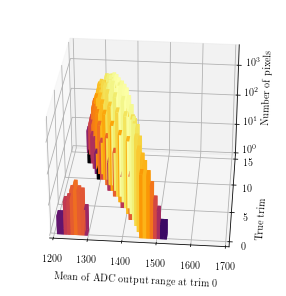

10.0


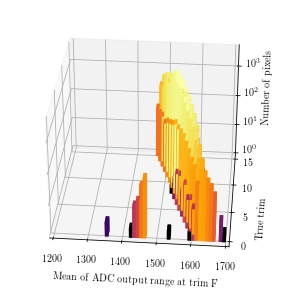

0.4


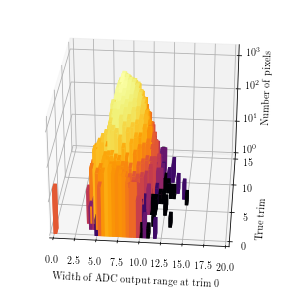

0.4


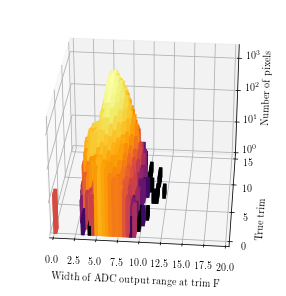

1.0


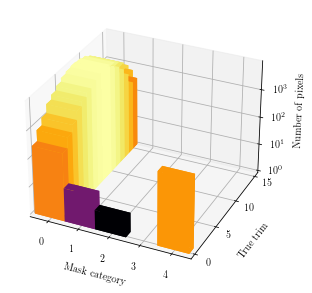

In [9]:
plotCorrelation(tMean0,trim, [1200, 1700], [0, 15], [50, trimBinEdges], xLabel="Mean of ADC output range at trim 0", yLabel="True trim", zLogScale=True, c=True, cameraAngle=(30, -85), savefig=True, figsize=(5,5), showTitle=False, filename="0MeanVsTrim.pdf", formatYAxisForTrim=True)
plotCorrelation(tMeanF,trim, [1200, 1700], [0, 15], [50, trimBinEdges], xLabel="Mean of ADC output range at trim F", yLabel="True trim", zLogScale=True, c=True, cameraAngle=(30, -85), savefig=True, figsize=(5,5), showTitle=False, filename="fMeanVsTrim.pdf", formatYAxisForTrim=True)

plotCorrelation(tWidth0,trim, [0, 20], [0, 15], [50, trimBinEdges], xLabel="Width of ADC output range at trim 0", yLabel="True trim", zLogScale=True, c=True, cameraAngle=(30, -85), savefig=True, figsize=(5,5), showTitle=False, filename="0WidthVsTrim.pdf", formatYAxisForTrim=True)
plotCorrelation(tWidthF,trim, [0, 20], [0, 15], [50, trimBinEdges], xLabel="Width of ADC output range at trim F", yLabel="True trim", zLogScale=True, c=True, cameraAngle=(30, -85), savefig=True, figsize=(5,5), showTitle=False, filename="fWidthVsTrim.pdf", formatYAxisForTrim=True)

plotCorrelation(mask,trim, [-0.5, 4.5], [0, 15], [5, trimBinEdges], xLabel="Mask category", yLabel="True trim", zLogScale=True, c=True, cameraAngle=(30, -65), savefig=True, figsize=(5,5), showTitle=False, filename="maskVsTrim.pdf", bbox=transforms.Bbox([[0.8,0.5], [4.9,4.2]]), formatYAxisForTrim=True)

10.0


C:\Users\Daniel\AppData\Local\Temp/ipykernel_16752/3362741535.py:38: RuntimeWarning: divide by zero encountered in log10
  barHeight = np.log10(hist.ravel())


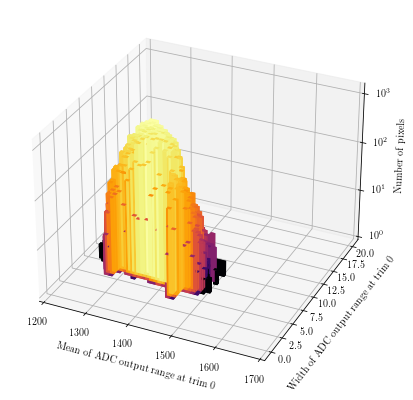

10.0


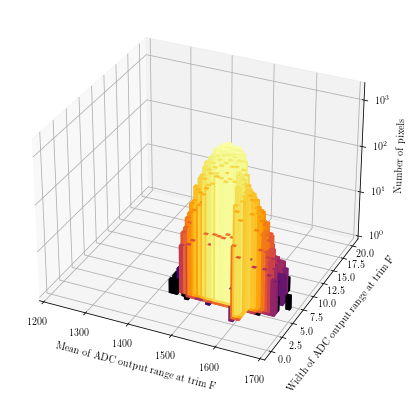

In [32]:

plotCorrelation(tMean0,tWidth0, [1200, 1700], [0, 20], [50, 50], xLabel="Mean of ADC output range at trim 0", yLabel="Width of ADC output range at trim 0", zLogScale=True, c=True, cameraAngle=(30, -65), savefig=True, figsize=(7,7), showTitle=False, filename="0MeanVs0Width.pdf", bbox=transforms.Bbox([[1,0.5], [6.8,5.8]]))
plotCorrelation(tMeanF,tWidthF, [1200, 1700], [0, 20], [50, 50], xLabel="Mean of ADC output range at trim F", yLabel="Width of ADC output range at trim F", zLogScale=True, c=True, cameraAngle=(30, -65), savefig=True, figsize=(7,7), showTitle=False, filename="fMeanVsFWidth.pdf", bbox=transforms.Bbox([[1,0.5], [6.8,5.8]]))